# PC-Gym - A Gym Environment for Process Control
 This is showcase for the PC-Gym library with a from-scratch implementation of DDPG.

In [1]:
from pcgym import make_env
import numpy as np 
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
# Set random seeds for reproducibility 
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Environment Setup


The next few cells create the environment of a CSTR reactor using the PC-Gym library. This defines the transition function $$p(s'|s,a)$$ and the reward function $$r(s,a)$$



The process control problem is a regulatory problem, where the goal is to keep the concentration of species A at a setpoint of 0.85 mol/L for the first third, then bring it up to 0.9 mol/L and back down to 0.87mol/L for the last third of the episode.  The action is the cooling water temperature, which is a continuous variable between 295 K and 302 K. The state is the concentration of species A, the temperature of the reactor, and the current setpoint.


In [2]:
T = 26
nsteps = 30
SP = {
    'Ca': [0.85 for i in range(int(nsteps/3))] + [0.9 for i in range(int(nsteps/3))]+ [0.87 for i in range(int(nsteps/3))],
}

Below we define the reward function $$r(s,a), $$ which is the negative squared error between the setpoint and the concentration of species A - the control effort. This can be described as:
$$r(s,a) = -(c_A - c_A^*)^2 - a^2$$

In [3]:
import numpy as np

def sp_track_reward(self,x,u,con):
    Sp_i = 0
    cost = 0 
    R = 0.1
    if not hasattr(self, 'u_prev'):
        self.u_prev = u

    for k in self.env_params["SP"]:
        i = self.model.info()["states"].index(k)
        SP = self.SP[k]
        
        o_space_low = self.env_params["o_space"]["low"][i] 
        o_space_high = self.env_params["o_space"]["high"][i] 

        x_normalized = (x[i] - o_space_low) / (o_space_high - o_space_low)
        setpoint_normalized = (SP - o_space_low) / (o_space_high - o_space_low)

        r_scale = self.env_params.get("r_scale", {})

        cost += (np.sum(x_normalized - setpoint_normalized[self.t]) ** 2) * r_scale.get(k, 1) # Setpoint tracking cost

        Sp_i += 1
    u_normalized = (u - self.env_params["a_space"]["low"]) / (
        self.env_params["a_space"]["high"] - self.env_params["a_space"]["low"]
    )
    u_prev_norm =  (self.u_prev - self.env_params["a_space"]["low"]) / (
        self.env_params["a_space"]["high"] - self.env_params["a_space"]["low"]
    )
    self.u_prev = u

    # Add the control cost
    cost += np.sum(R * (u_normalized-u_prev_norm)**2) # Control effort cost
    r = -cost
    try:
        return r[0]
    except Exception:
        return r

Below we make the environment, first by creating a dictionary of the environment's parameters, then by calling the `make_env` function from the PC-Gym library. 

In [4]:
# Continuous box action space
action_space = {
    'low': np.array([295.], dtype=np.float32),
    'high':np.array([302.], dtype=np.float32) 
}

# Continuous box observation space
observation_space = {
    'low' : np.array([0.7, 300., 0.7], dtype=np.float32),
    'high' : np.array([1., 350., 1], dtype=np.float32)  
}

r_scale ={
    'Ca': 1e3 #Reward scale for each state
}
env_params = {
    'N': nsteps, # Number of time steps
    'tsim': T, # Simulation Time
    'SP': SP, # Setpoint
    'o_space' : observation_space, # Observation space
    'a_space' : action_space, # Action space
    'x0': np.array([0.8, 330, SP['Ca'][0]]), # Initial conditions 
    'model': 'cstr', # Select the model
    'r_scale': r_scale, # Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, # Normalise the actions
    'normalise_o': True, # Normalise the states,
    'noise': True, # Add noise to the states
    'integration_method': 'casadi', # Select the integration method
    'noise_percentage': 0.001, # Noise percentage
    'custom_reward': sp_track_reward
}

env = make_env(env_params)

## DDPG 

Since the state and action spaces are continuous we will use the [Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971) (Lillicrap et. al., 2019) algorithm. The DDPG algorithm is an actor-critic algorithm that uses two neural networks: one for the actor and one for the critic. The actor network takes the state as input and outputs the action, while the critic network takes the state and action as input and outputs the Q-value.

### Actor and Critic Networks
The actor network parameterizes the *deterministic* policy as a function, $$a = \mu_\theta(s),$$ that maps states to actions, while the critic network estimates the Q-value function $$Q_\phi(s, a).$$ Their architectures are described in the code below.

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        
        # Action rescaling - key improvement from CleanRL
        self.register_buffer("action_scale", torch.tensor(max_action, dtype=torch.float32))
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale


class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



### Replay Buffer

The replay buffer, denoted as $\mathcal{D}$, is a finite-sized memory that stores transitions $(s_t, a_t, r_t, s_{t+1}, d_t)$ encountered during agent-environment interaction. At each training step, a minibatch of experiences is sampled uniformly from $\mathcal{D}$ to update the agent. 

The replay buffer is creates in the cell below.

In [6]:
class ReplayBuffer:
    """
    Experience Replay Buffer
    Stores transitions and samples random batches for training
    """
    def __init__(self, capacity=1000000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        
        # Convert to tensors for PyTorch training
        state = torch.FloatTensor(np.array(state))
        action = torch.FloatTensor(np.array(action))
        reward = torch.FloatTensor(np.array(reward)).unsqueeze(1)
        next_state = torch.FloatTensor(np.array(next_state))
        done = torch.FloatTensor(np.array(done)).unsqueeze(1)
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

### Action Noise

The action selected by the policy with exploration noise is given by:

$$
a_t = \mu_\theta(s_t) + \epsilon_t
$$

where:
- $\mu_\theta(s_t)$ is the deterministic action output by the actor network (policy) for state $s_t$,
- $\epsilon_t$ is the exploration noise, typically sampled from a Gaussian distribution: $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$.

The implementation of the exploration noise $\epsilon_t$ is created in the cell below.

In [7]:
class GaussianNoise:
    def __init__(self, action_dim, sigma=0.1, sigma_decay=0.9999, sigma_min=0.01):
        self.action_dim = action_dim
        self.sigma = sigma
        self.sigma_decay = sigma_decay
        self.sigma_min = sigma_min
    
    def sample(self):
        return np.random.normal(0, self.sigma, self.action_dim)

### DDPG Agent

Below is the implementation of the DDPG agent, which encapsulates the actor and critic networks, experience replay, action selection with exploration noise, and the training procedure. This class provides all the necessary methods for interacting with the environment, storing transitions, and updating the policy and value networks.

In [8]:
class DDPGAgent:
    """
    DDPG Agent Implementation 

    """
    def __init__(self, state_dim, action_dim, max_action, lr_actor=3e-4, lr_critic=3e-4, 
                gamma=0.99, tau=0.005, hidden_dim=256, buffer_size=int(1e6),
                policy_frequency=2, exploration_noise=0.1):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Store hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.max_action = max_action
        self.policy_frequency = policy_frequency
        self.exploration_noise = exploration_noise
        self.training_step = 0
        
        # Initialize networks
        self.actor = Actor(state_dim, action_dim, max_action, hidden_dim).to(self.device)
        self.critic = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        
        # Initialize target networks 
        self.actor_target = Actor(state_dim, action_dim, max_action, hidden_dim).to(self.device)
        self.critic_target = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        
        # Copy weights to target networks
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
                
        self.replay_buffer = ReplayBuffer(
            buffer_size,
        )
        
        # Noise for exploration
        self.noise = GaussianNoise(action_dim, sigma=exploration_noise)
        
        # Training statistics
        self.actor_losses = []
        self.critic_losses = []
    
    def select_action(self, state, add_noise=True):
        """Select action using current policy with improved noise handling"""
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        
        with torch.no_grad():
            action = self.actor(state).cpu().numpy().flatten()
        
        if add_noise:
            # Add exploration noise
            action += self.noise.sample()
            
            # Decay noise over time
            self.noise.sigma = max(self.noise.sigma * self.noise.sigma_decay, self.noise.sigma_min)

            # Clip to action bounds
            action = np.clip(action, -self.max_action, self.max_action)
        
        return action
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer"""
        self.replay_buffer.add(state, next_state, action, reward, done, {})
    
    def train(self, batch_size=256):
        """Train the agent using a batch of experiences"""
        if len(self.replay_buffer) < batch_size:
            return
        
        # Sample batch from replay buffer
        s, a, r, sp, dones = self.replay_buffer.sample(batch_size)
        
        # --- Update Critic ---
        with torch.no_grad():
            # Compute target Q-value using target networks
            next_actions = self.actor_target(sp)
            target_q = self.critic_target(sp, next_actions)
            target_q = r.flatten() + (1 - dones.flatten()) * self.gamma * target_q.view(-1)
        
        # Compute current Q-value
        current_q = self.critic(s, a).view(-1)
        
        # Critic loss (MSE between current and target Q-values)
        critic_loss = F.mse_loss(current_q, target_q)
        
        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        self.training_step += 1
        
        # --- Delayed Policy Updates ---
        if self.training_step % self.policy_frequency == 0:
            # Update Actor
            actor_loss = -self.critic(s, self.actor(s)).mean()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            # Soft update target networks
            self.soft_update(self.critic_target, self.critic)
            self.soft_update(self.actor_target, self.actor)
            
            # Store losses for plotting
            self.actor_losses.append(actor_loss.item())
        
        self.critic_losses.append(critic_loss.item())
    
    def soft_update(self, target, source):
        """Soft update target network parameters """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


### Training Loop

In [9]:
def train_ddpg(env, total_episodes=500, max_steps=T):
    """
    Train DDPG agent on the specified environment
    """
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    # Initialize agent
    agent = DDPGAgent(state_dim, action_dim, max_action)
    
    # Training statistics
    episode_rewards = []
    episode_lengths = []
    
    print("\nStarting training...")
    episode_reward = 0
    progress_bar = tqdm(range(total_episodes), desc="Training Progress")
    
    for episode in progress_bar:
        state, _ = env.reset()
        
        episode_reward = 0
        episode_length = 0
    
        for step in range(nsteps):
            # Select action with exploration noise
            action = agent.select_action(state, add_noise=True)
            
            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition in replay buffer
            agent.replay_buffer.push(state, action, reward, next_state, done)
            
            # Train agent
            agent.train()
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if done:
                break
        progress_bar.set_postfix({
        'Reward': f"{episode_reward:.2f}", 
        })
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

    env.close()
    return agent, episode_rewards, episode_lengths

### Evaluation Loop

In [10]:
def evaluate_agent(agent, env, num_episodes=10):
    """Evaluate trained agent without exploration noise and return states and actions"""
    
    eval_rewards = []
    eval_states = []
    eval_actions = []

    # Preallocate arrays for efficiency
    eval_rewards_arr = np.zeros((num_episodes, 1))
    eval_states_arr = np.zeros((num_episodes, nsteps + 1, env.observation_space.shape[0]))
    eval_actions_arr = np.zeros((num_episodes, nsteps, env.action_space.shape[0]))

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        states = [state.copy()]
        actions = []
        rewards = []

        for t in range(nsteps):
            action = agent.select_action(state, add_noise=False)  # No noise for evaluation
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            actions.append(action.copy())
            rewards.append(reward)
            state = next_state
            states.append(state.copy())
            if terminated or truncated:
                break

        # Store results in arrays
        eval_rewards_arr[episode,] = sum(rewards)
        eval_states_arr[episode, :len(states)] = np.array(states)
        eval_actions_arr[episode, :len(actions)] = np.array(actions)

        eval_rewards.append(episode_reward)
        eval_states.append(np.array(states))
        eval_actions.append(np.array(actions))


    env.close()
    return eval_rewards_arr, eval_states_arr, eval_actions_arr

## Run the Training and Evalutation loops

In [11]:
trained_agent, rewards, lengths = train_ddpg(env, total_episodes=100)

print("\nEvaluating trained agent...")
eval_rewards, eval_states,eval_actions = evaluate_agent(trained_agent, env, num_episodes=10)
print(f"Average evaluation reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")

Using device: cpu

Starting training...


Training Progress: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s, Reward=-87.13]



Evaluating trained agent...
Average evaluation reward: -84.90 ± 1.85


### Training Evaluation

In [12]:
def plot_training_results(episode_rewards, episode_lengths, actor_losses, critic_losses):
    """Plot training performance metrics"""
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    
    # Episode rewards
    ax1.plot(episode_rewards, color='tab:red', linewidth=0.8, alpha=0.5)
    # Plot moving average for clearer trend
    window = 10
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg, 
            color='tab:red', linewidth=2, label=f'Moving Average (window={window})')
        # Plot moving standard deviation
        moving_std = [np.std(episode_rewards[i-window+1:i+1]) for i in range(window-1, len(episode_rewards))]
        ax1.fill_between(range(window-1, len(episode_rewards)), 
                 moving_avg - moving_std, moving_avg + moving_std, 
                 color='tab:red', alpha=0.2, label='Moving Std', edgecolor='none')
        ax1.legend()
        ax1.set_title('Episode Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True, alpha=0.3)

    
    plt.tight_layout()
    plt.show()


Plotting training results...


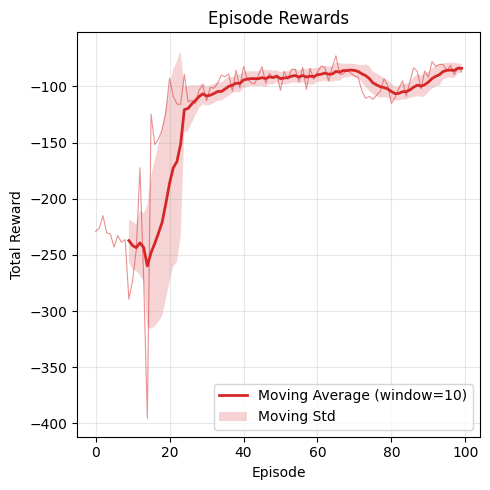

In [13]:
print("\nPlotting training results...")
plot_training_results(rewards, lengths, trained_agent.actor_losses, trained_agent.critic_losses)

## Final Policy Visualization

We can visualize the final policy by running a rollout of the trained agent in the environment. The code below shows how to do this using the `plot_rollout` method from the PC-Gym library.

In [17]:
class DDPGPolicy:
    def predict(o, deterministic = False):
        u = trained_agent.select_action(o, add_noise=False)        
        return u, 0

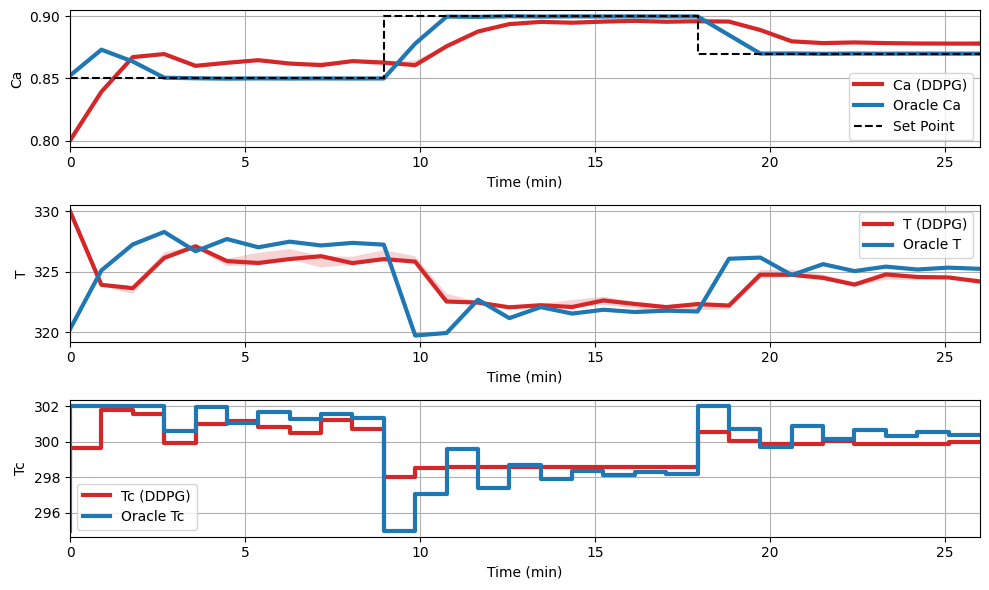

In [20]:
evaluator, data = env.plot_rollout({'DDPG': DDPGPolicy,}, reps = 3, oracle=True, dist_reward=False)